# **Homework 12 - Reinforcement Learning**

If you have any problem, e-mail us at ntu-ml-2022spring-ta@googlegroups.com



## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1


Next, set up virtual display，and import all necessaary packages.

In [1]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
from argparse import Namespace
from collections import deque

# Warning ! Do not revise random seed !!!
# Your submission on JudgeBoi will not reproduce your result !!!
Make your HW result to be reproducible.


In [2]:
seed = 543 # Do not change this
def fix(env, seed):
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.set_deterministic(True)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [3]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

[W Context.cpp:70] Warning: torch.use_deterministic_algorithms is in beta, and its design and functionality may change in the future. (function operator())


## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment". 

In this homework, we will utilize the function `step()` to control the action of "Agent". 

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [4]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [5]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment. 
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [6]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [7]:
random_action = env.action_space.sample()
print(random_action)

0


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [8]:
observation, reward, done, info = env.step(random_action)

In [9]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. 

In [10]:
print(reward)

-0.8588845024543161


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

In [11]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

## Advantage Actor Critic
Ref: https://github.com/tejaskhot/pytorch-LunarLander/blob/master/a2c.py  
Now, we can build actor and critic network.  
Actor network will return one of action in the action space.  
Critic network will return the expected value.

In [12]:
class Actor(nn.Module):

    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1),
        )

    def forward(self, state):
        # Returning probability of each action
        return self.fc(state)

class Critic(nn.Module):

    def __init__(self, state_size=8, hidden_size=64, drop_prob=0.3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, state):
        # critic: evaluates being in the state s_t
        return self.fc(state)

Then, we need to build a simple agent. The agent will acts according to the output of the actor / critic network above. There are a few things can be done by agent:
- `learn()`：update the actor network from log probabilities and advantages and the critic network from rewards.
- `sample()`：After receiving observation from the environment, utilize actor network to tell which action to take and critic network to predict the state value. The return values of this function includes action, log probabilities and state value.
- `step()`: Performs a step, if reach the `update_freq` then call `learn()` to update the agent / critic network.
- `empty()`: Empty the experience list includes (reward, log_prob, next_state_value, state_value, done).

In [13]:
from torch.optim.lr_scheduler import StepLR
class ActorCriticAgent():
    
    def __init__(self, actor, critic, **kwargs):
        # Configuration parameters
        self.config = Namespace(**kwargs)

        # Actor-Critic Network
        self.actor = actor
        self.critic = critic
        self.optimizer_actor = getattr(optim, self.config.optimizer)(self.actor.parameters(), lr=self.config.learning_rate)
        self.optimizer_critic = getattr(optim, self.config.optimizer)(self.critic.parameters(), lr=self.config.learning_rate)
        self.loss_fn = nn.SmoothL1Loss()

        # Step and update frequency
        self.step_t = 0
        self.update_freq = self.config.update_freq

        # Records
        self.loss_values = []

        self.empty()

    def step(self, log_probs, rewards, state_values, next_state_values, dones):
        self.step_t = (self.step_t + 1) % self.update_freq

        # Append the experiences
        self.rewards += rewards
        self.log_probs += log_probs
        self.state_values += state_values
        self.next_state_values += next_state_values
        self.dones += dones

        # Update Network
        if self.step_t == 0:
            self.learn(
                torch.stack(self.log_probs),                                # log probabilities
                torch.tensor(self.rewards, dtype=torch.float32),            # discounted cumulative rewards
                torch.tensor(self.state_values, requires_grad=True),        # state_values
                torch.tensor(self.next_state_values, requires_grad=True),   # next_state_values
                torch.tensor(self.dones),                                   # dones
            )
            # Empty the experiences
            self.empty()

    def empty(self):
        """ Empty the experience list """
        self.rewards = []
        self.log_probs = []
        self.state_values = []
        self.next_state_values = []
        self.dones = []

    def learn(self, log_probs, rewards, state_values, next_state_values, dones):
        """
        Update value parameters using given experience list.

        Arguments:
            log_probs (torch.Tensor): log probabilities
            rewards (torch.Tensor): discounted cumulative rewards
            state_values (torch.Tensor): predicted current state_values
            next_state_values (torch.Tensor): predicted next state_values
            dones (torch.Tensor): dones
        """
        # Advantages
        advantages = []
        for R, next_value, value in zip(rewards, next_state_values, state_values):
            advantages.append(R + next_value.item() - value.item())

        # Normalization
        advantages = torch.tensor(advantages)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-9)

        # Calculate loss
        loss_actor = (-log_probs * advantages).sum()
        loss_critic = self.loss_fn(state_values, rewards)
        self.loss_values.append(loss_actor.detach().item() + loss_critic.detach().item())

        # Backpropagation
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()
        loss_actor.backward()
        loss_critic.backward()
        self.optimizer_actor.step()
        self.optimizer_critic.step()

    def sample(self, state):
        """
        Returns action, log_prob, state_value for given state.
        
        Arguments:
            state (array_like): current state
        """
        action_prob = self.actor(torch.FloatTensor(state))
        state_value = self.critic(torch.FloatTensor(state))
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)
        return action.item(), log_prob, state_value

## Configurations

In [14]:
Actor_config = Namespace(
    state_size = 8,
    action_size = 4,
    hidden_size = 64,
)

Critic_config = Namespace(
    state_size = 8,
    hidden_size = 64,
    drop_prob = 0.3,
)

Agent_config = Namespace(
    optimizer = 'Adam',
    learning_rate = 5e-4,
    update_freq = 5,
)

ActorCritic_config = Namespace(
    n_episodes = 10000,
    max_t = None,
    window_size = 500,
    gamma = 0.99,
)

Actor_config, Critic_config, Agent_config, ActorCritic_config

(Namespace(action_size=4, hidden_size=64, state_size=8),
 Namespace(drop_prob=0.3, hidden_size=64, state_size=8),
 Namespace(learning_rate=0.0005, optimizer='Adam', update_freq=5),
 Namespace(gamma=0.99, max_t=None, n_episodes=10000, window_size=500))

Lastly, build a network and agent to start training.

In [15]:
actor = Actor(**vars(Actor_config))
critic = Critic(**vars(Critic_config))
agent = ActorCriticAgent(actor, critic, **vars(Agent_config))

## Training Agent

Now let's start to train our A2C agent.
Through taking all the interactions between agent and environment as training data, the A2C network can learn from all these attempts.

In [16]:
def ActorCritic(n_episodes=2000, max_t=1000, window_size=100, gamma=0.99):
    """
    A2C Algorithm.
    Arguments:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode(None: No limit)
        window_size (int): maximum size to record observed total rewards
        gamma (float): discount factor
    """
    agent.actor.train()                         # Switch network into training mode
    agent.critic.train()                        # Switch network into training mode

    total_rewards = []                          # list containing total reward from each episode
    final_rewards = []                          # list containing final reward from each episode
    rewards_window = deque(maxlen=window_size)  # last window_size rewards
    best_reward = -np.inf

    progress_bar = tqdm(range(1, n_episodes + 1))
    for i_episode in progress_bar:
        state = env.reset()                     # Reset the environment
        total_reward, reward = 0, 0             # Total reward / current reward
        max_t = max_t if max_t else np.inf      # max_t is infinite if the value id None
        total_step = 0                          # Step of each episode

        rewards = []
        log_probs = []
        state_values = []
        next_state_values = []
        dones = []
        while True:
            # Reach the max_t
            if total_step == max_t:
                break

            # Sample an action and interact with the environment
            action, log_prob, state_value = agent.sample(state) # action at, log(at|st)
            next_state, reward, done, _ = env.step(action)
            _, __, next_state_value = agent.sample(next_state)  # action at, log(at+1|st+1)

            # Information about a state
            next_state_values.append(next_state_value)
            state_values.append(state_value)
            rewards.append(reward)
            dones.append(done)
            log_probs.append(log_prob)

            state = next_state
            total_reward += reward
            total_step += 1

            if done:
                break

        """ Discounted cumulative rewards """
        discounted_rewards = []
        T_max = len(rewards)
        for t in range(T_max):
            discounted_rewards.append(sum([r * (gamma**power) for r, power in zip(rewards[t:], range(T_max - t))]))
        assert (len(rewards) == len(discounted_rewards)), "Dimension does not match."
        rewards = discounted_rewards

        final_rewards.append(reward)            # save final reward in episode
        total_rewards.append(total_reward)      # save total rewards in episode
        rewards_window.append(total_reward)     # save total rewards in episode

        # Agent performs one step
        agent.step(log_probs, rewards, state_values, next_state_values, dones)

        # record training process
        progress_bar.set_description(f"Total: {total_reward: 4.1f}, Final: {reward: 4.1f}")
        # Information
        print(f'Episode {i_episode}\tAverage {window_size} Score: {np.mean(rewards_window): 4.1f}\tScore: {total_reward: 4.1f}{" "*5}', end='\r')
        if i_episode % window_size == 0:
            print(f'Episode {i_episode}\tAverage {window_size} Score: {np.mean(rewards_window): 4.1f}')

        if total_reward > best_reward:
            torch.save(agent.actor.state_dict(), f'actor.pt')
            best_reward = total_reward
    return total_rewards, final_rewards

In [17]:
total_rewards, final_rewards = ActorCritic(**vars(ActorCritic_config))

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 500	Average 500 Score: -168.3	Score: -167.3     
Episode 1000	Average 500 Score: -129.7	Score: -109.5     
Episode 1500	Average 500 Score: -92.1	Score: -85.1       
Episode 2000	Average 500 Score: -32.2	Score:  82.6      
Episode 2500	Average 500 Score:  28.8	Score:  14.6      
Episode 3000	Average 500 Score:  91.2	Score:  147.0     
Episode 3500	Average 500 Score:  96.1	Score: -23.2       
Episode 4000	Average 500 Score:  105.5	Score:  142.6     
Episode 4500	Average 500 Score:  127.0	Score:  159.8     
Episode 5000	Average 500 Score:  135.0	Score:  131.1     
Episode 5500	Average 500 Score:  145.8	Score:  141.8     
Episode 6000	Average 500 Score:  200.1	Score:  303.4     
Episode 6500	Average 500 Score:  231.7	Score:  299.0     
Episode 7000	Average 500 Score:  237.8	Score:  274.4     
Episode 7500	Average 500 Score:  238.0	Score:  275.4     
Episode 8000	Average 500 Score:  221.3	Score:  287.2     
Episode 8500	Average 500 Score:  251.9	Score:  293.9     
Episode 9000	Avera

### Training Result
During the training process, we recorded `total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `total_reward` will increase.
The visualization of the training process is shown below:  


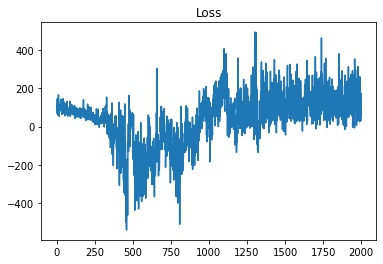

In [18]:
plt.plot(agent.loss_values)
plt.title("Loss")
plt.show()

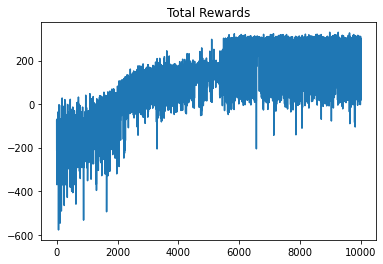

In [19]:
plt.plot(total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


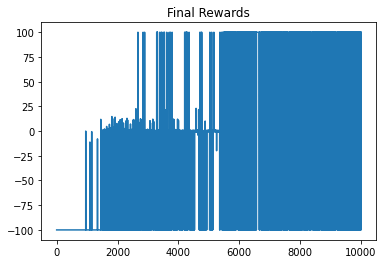

In [20]:
plt.plot(final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

284.0140434487449


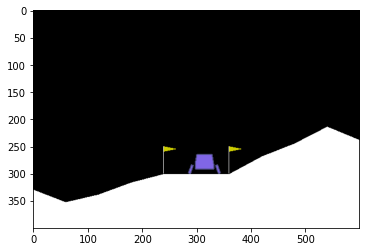

In [21]:
fix(env, seed)
agent.actor.eval()  # set the network into evaluation mode
agent.critic.eval()
NUM_OF_TEST = 5 # Do not revise this !!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()

    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False
    while not done:
        action, _, __ = agent.sample(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)

        total_reward += reward

        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

    print(total_reward)
    test_total_reward.append(total_reward)

    action_list.append(actions) # save the result of testing 

In [22]:
print(np.mean(test_total_reward))

283.6601476684121


Action list

In [23]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 3, 0, 0, 0, 2, 3, 2, 1, 0, 2, 0, 0, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 3, 2, 2, 2, 0, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 3, 2, 2, 2, 0, 0, 2, 3, 3, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 3, 3, 3, 0, 0, 3, 0, 3, 3, 2, 2, 3, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 3, 2, 2, 3, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 3, 2, 2, 

/home/tienyi/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Analysis of actions taken by agent

In [24]:
distribution = {}
for actions in action_list:
    for action in actions:
        if action not in distribution.keys():
            distribution[action] = 1
        else:
            distribution[action] += 1
print(distribution)

{0: 509, 1: 111, 3: 109, 2: 453}


Saving the result of Model Testing


In [25]:
PATH = "Action_List_A2C.npy" # Can be modified into the name or path you want

In [26]:
np.save(PATH ,np.array(action_list)) 

/tmp/ipykernel_792558/3777543850.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save(PATH ,np.array(action_list))


# Server 
The code below simulate the environment on the judge server. Can be used for testing.

Your reward is : 263.83
Your reward is : 283.67
Your reward is : 283.16
Your reward is : 303.62
Your reward is : 284.01


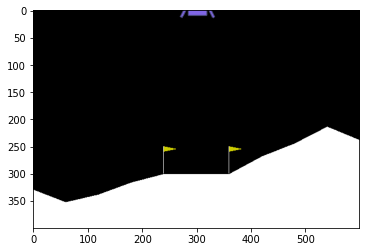

In [27]:
action_list = np.load(PATH, allow_pickle=True) # The action list you upload
seed = 543 # Do not revise this
fix(env, seed)

agent.actor.eval()  # set network to evaluation mode
agent.critic.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
    print("Wrong format of file !!!")
    exit(0)

for actions in action_list:
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False

    for action in actions:

        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break

    print(f"Your reward is : %.2f"%total_reward)
    test_total_reward.append(total_reward)

# Your score

In [28]:
print(f"Your final reward is : {np.mean(test_total_reward):.2f}")

Your final reward is : 283.66


## Reference

Below are some useful tips for you to get high score.

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
